In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func
from sqlalchemy import inspect 

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite", echo = False)

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables 
Base.prepare(engine, reflect = True)


In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
measurement = Base.classes.measurement 
station = Base.classes.station 

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
inspector = inspect(engine)
inspector.get_table_names()
column = inspector.get_columns('measurement')
for c in column:
    print(c['name'])
session.query(measurement.date).order_by(measurement.date).first()
session.query(measurement.date).order_by(measurement.date.desc()).first()
session.query(measurement.date,measurement.prcp).filter(measurement.date >='2016-08-23').limit(10).all()


id
station
date
prcp
tobs


[('2016-08-23', 0.0),
 ('2016-08-24', 0.08),
 ('2016-08-25', 0.08),
 ('2016-08-26', 0.0),
 ('2016-08-27', 0.0),
 ('2016-08-28', 0.01),
 ('2016-08-29', 0.0),
 ('2016-08-30', 0.0),
 ('2016-08-31', 0.13),
 ('2016-09-01', 0.0)]

In [11]:
# Calculate the date 1 year ago from the last data point in the database
session.query(measurement.date).order_by(measurement.date.desc()).first()
query_date = dt.date(2017, 8, 23) - dt.timedelta(days = 365)
query_date 

datetime.date(2016, 8, 23)

In [12]:
# Perform a query to retrieve the data and precipitation scores
#shown above(e.g. 0.0, 0.08, 0.01...etc.)

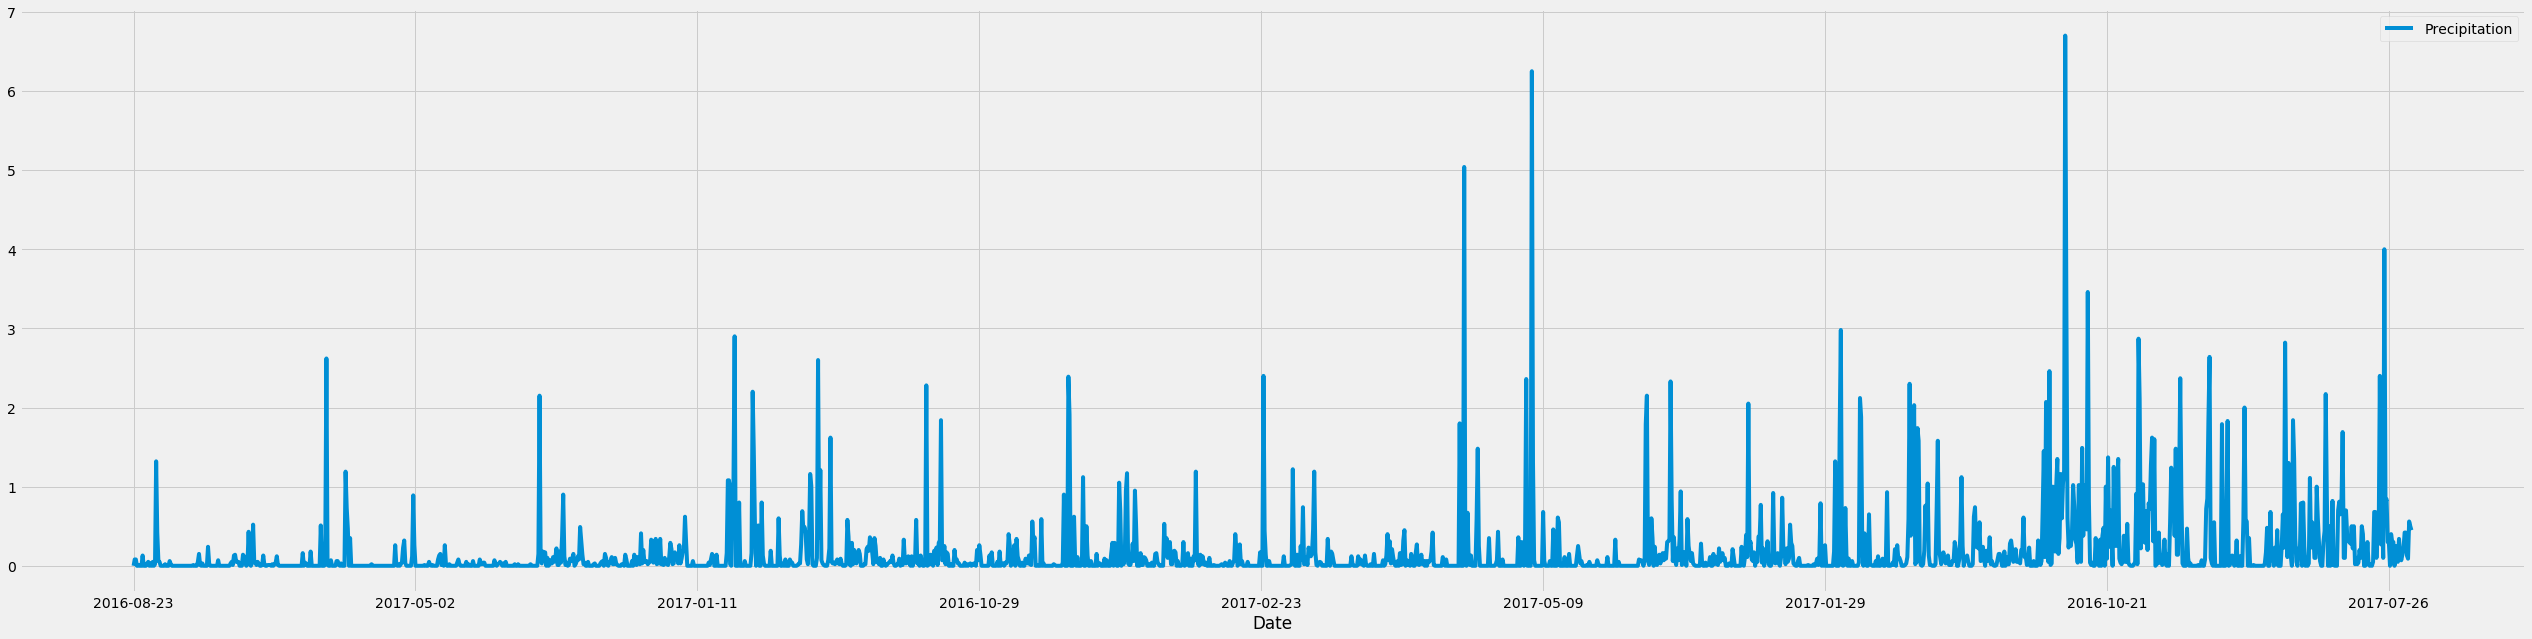

In [13]:
# Save the query results as a Pandas DataFrame and set the index to the date column
prcp_data = session.query(measurement.date,measurement.prcp).filter(measurement.date >='2016-08-23').all()
# Sort the dataframe by date
prcp_df = pd.DataFrame(prcp_data, columns = ['Date','Precipitation'])
prcp_df
prcp_cleaned = prcp_df.dropna()
prcp_cleaned.set_index(prcp_cleaned['Date'], inplace = True)
# Use Pandas Plotting with Matplotlib to plot the data
prcp_cleaned.plot(figsize=(40,10))
plt.show()


In [14]:
# Use Pandas to calcualte the summary statistics for the precipitation data
round(prcp_df.describe(),5)


,Precipitation
count,2021.00000
mean,0.17728
std,0.46119
min,0.00000
25%,0.00000
50%,0.02000
75%,0.13000
max,6.70000


In [15]:
# Design a query to show how many stations are available in this dataset?    
stations_count = session.query(measurement.station).distinct().count()
print(f'There are {stations_count} stations.')

There are 9 stations.


In [16]:
# What are the most active stations? (i.e. what stations have the most rows)?
active_stations = session.query(measurement.station, func.count(measurement.station)).group_by(measurement.station).order_by(func.count(measurement.station).desc()).all()
print(f'Station {active_stations[0][0]} is the most active station, which has {active_stations[0][1]} observations')

# List the stations and the counts in descending order.
active_stations

Station USC00519281 is the most active station, which has 2772 observations


[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [17]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
lowest_tem = session.query(measurement.tobs).order_by(measurement.tobs).first()
print(f'The lowest temperature is {lowest_tem[0]} ')

# highest temperature recorded, and average temperature of the most active station?
highest_tem = session.query(measurement.tobs).order_by(measurement.tobs.desc()).first()
ave_tem = session.query(func.avg(measurement.tobs)).filter(measurement.station == 'USC00519281').all()
print(f'The highest temperature is {highest_tem[0]} and the average temperature of the most active station is {ave_tem[0]}')

The lowest temperature is 53.0 
The highest temperature is 87.0 and the average temperature of the most active station is (71.66378066378067,)


Station USC00519281 has the highest temperature observations: 2772


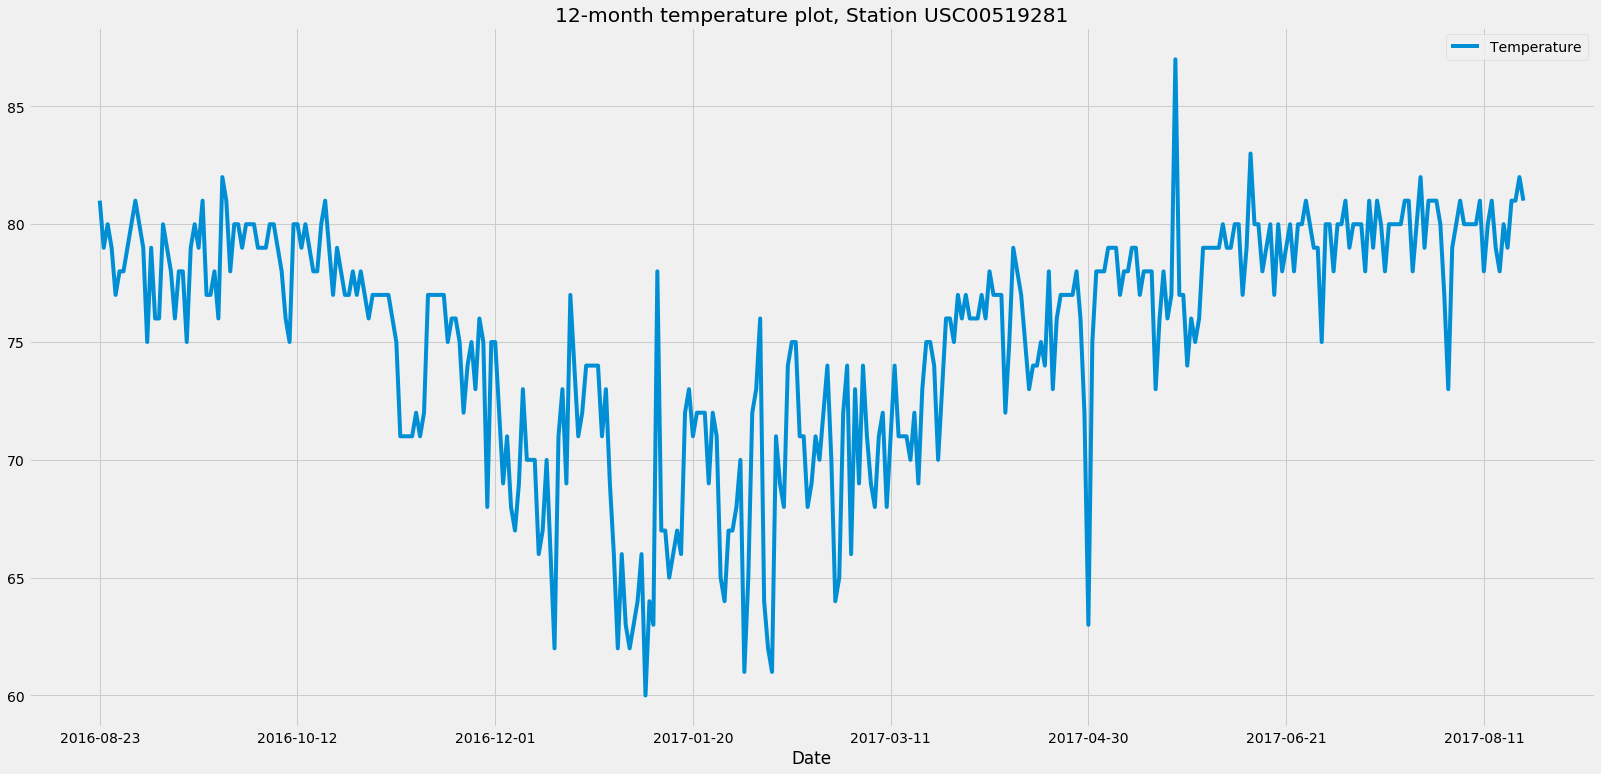

In [18]:
# Choose the station with the highest number of temperature observations.
highest_num_tem = session.query(measurement.station, func.count(measurement.tobs)).group_by(measurement.station).order_by(func.count(measurement.tobs).desc()).first()
print(f'Station {highest_num_tem[0]} has the highest temperature observations: {highest_num_tem[1]}')
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
twelve_month = session.query(measurement.tobs, measurement.date).filter(measurement.date >= '2016-08-23', measurement.station == 'USC00519397').all()
twelve_month

twelve_month_df = pd.DataFrame(twelve_month, columns = ['Temperature','Date'])
twelve_month_df.set_index(twelve_month_df['Date'], inplace = True)
twelve_month_df.plot(figsize = (25,12))
plt.title('12-month temperature plot, Station USC00519281')
plt.show()

## Bonus Challenge Assignment

In [19]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(measurement.tobs), func.avg(measurement.tobs), func.max(measurement.tobs))\
    .filter(measurement.date >= start_date).filter(measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [20]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
previous_year = calc_temps('2012-02-28', '2012-03-05')
print(previous_year)

[(62.0, 69.57142857142857, 74.0)]


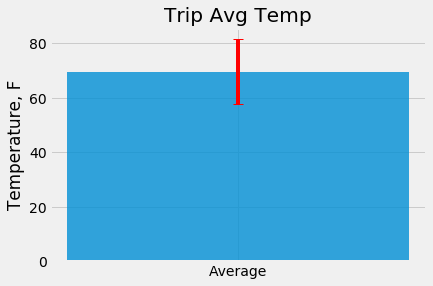

In [21]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


calc_df = pd.DataFrame(previous_year, columns = ['Min','Avg','Max'])
calc_df
yerr = calc_df['Max'] - calc_df['Min']
plt.bar('Average', calc_df['Avg'], yerr = yerr, align='center', alpha=0.8, ecolor='red', capsize=5)
plt.title('Trip Avg Temp')
plt.ylabel('Temperature, F')
plt.show()



In [22]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

trip_prcp = session.query(func.sum(measurement.prcp), measurement.station, station.name, station.latitude, station.longitude, station.elevation)\
.group_by(measurement.station).filter(measurement.date >= '2012-02-28', measurement.date <= '2012-03-05', measurement.station == station.station)\
.order_by(func.sum(measurement.prcp).desc()).all()
trip_prcp_df = pd.DataFrame(trip_prcp, columns = ['prcp','Station ID', 'Name', 'Latitude', 'Longitude', 'Elevation'])
trip_prcp_df


,prcp,Station ID,Name,Latitude,Longitude,Elevation
0,11.08,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9
1,10.32,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4
2,5.79,USC00513117,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6
3,3.84,USC00518838,"UPPER WAHIAWA 874.3, HI US",21.49920,-158.01110,306.6
4,2.92,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5
5,1.18,USC00519397,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0
6,0.76,USC00511918,"HONOLULU OBSERVATORY 702.2, HI US",21.31520,-157.99920,0.9
7,0.03,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0
8,0.00,USC00517948,"PEARL CITY, HI US",21.39340,-157.97510,11.9


In [23]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(measurement.tobs), func.avg(measurement.tobs), func.max(measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [24]:
# calculate the daily normals for your trip
# Set the start and end date of the trip
start_date = '2012-02-28'
end_date = '2012-03-05'

# Use the start and end date to create a range of dates

start = dt.datetime.strptime(start_date, '%Y-%m-%d')
end = dt.datetime.strptime(end_date, '%Y-%m-%d')

days = session.query(measurement.date).filter(measurement.date >= start_date, measurement.date <= end_date).group_by(measurement.date).all()

# Stip off the year and save a list of %m-%d strikngs
# Loop through the list of %m-%d strings and calculate the normals for each date
normal = []
normal_date = []
import re
for day in days:
    month_day = (re.findall(r'-(\d{2}-\d{2})',str(day))[0])
    normal.append(daily_normals(month_day))
    normal_date.append(month_day)   

In [25]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
from itertools import chain
flat_normal = list(chain.from_iterable(normal))
normal_df = pd.DataFrame(flat_normal, columns=['min','avg','max'])
normal_df['date'] = normal_date
normal_df.set_index('date', inplace = True)
normal_df

,min,avg,max
date,,,
02-28,65.0,70.655172,80.0
02-29,67.0,71.733333,79.0
03-01,64.0,70.032787,76.0
03-02,61.0,70.366667,78.0
03-03,60.0,70.068966,78.0
03-04,57.0,69.272727,77.0
03-05,60.0,67.890909,76.0


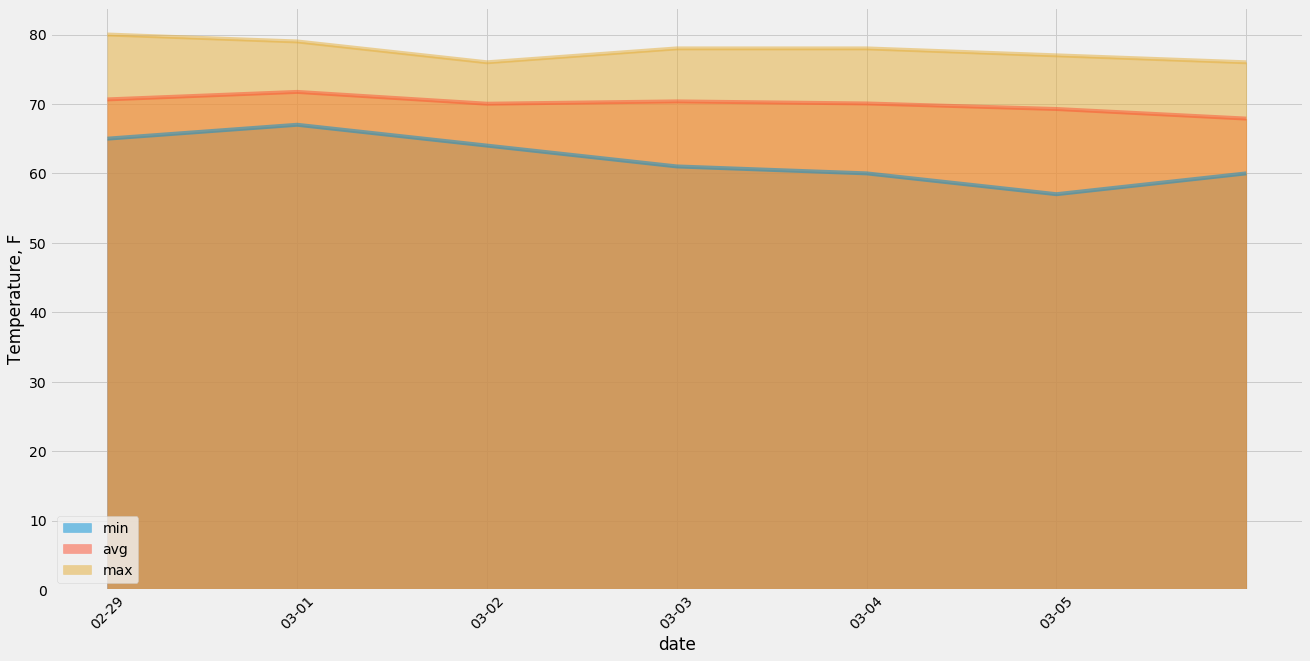

In [45]:
# Plot the daily normals as an area plot with `stacked=False`
normal_plot = normal_df.plot.area(figsize = (20, 10), stacked = False)
plt.ylabel('Temperature, F')
normal_plot.set_xticklabels(normal_date, rotation = 45)
plt.show()